In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/morph/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
from jax import jit, value_and_grad, vmap
from jax.tree_util import tree_structure
import optax
import numpy as onp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle as p
import time as t

In [3]:
import poppy
import astropy.units as u

In [4]:
from jaxinterp2d import interp2d

In [5]:
import equinox as eqx
import equinox

---
# Base Classes

In [6]:
# Base Classes
class Layer(eqx.Module):
    """
    Base Layer class
    Can optionally pass in 'function' in order to facilitate parameterised planes
    Can optionally pass in 'static' to automatically freeze in the parameters
    """
    size_in: int = equinox.static_field()
    size_out: int = equinox.static_field()
    
    def __init__(self, size_in, size_out):
        self.size_in = size_in
        self.size_out = size_out

class OpticalSystemDev(eqx.Module):
    """
    Base class defining some optical system
    
    Dev: Automatically returns intermediate wavefronts & pixescales for examination
    
    layers must be a list of Layer objects
    Each layer object can either be some optical operation, 
    transform, or NN type layer
    """
    layers: list # Can this be set to a static field?    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, wavel):
        
        # Inialise value and objects to store data
        functions, intermed_wavefronts, intermed_pixelscales = [], [], []
        wavefront, pixelscale = None, None
        
        # Inialise values and iterate 
        for i in range(len(self.layers)):
            wavefront, pixelscale = self.layers[i](wavefront, wavel, pixelscale)
            
            # Store Values in list
            intermed_wavefronts.append(wavefront)
            intermed_pixelscales.append(pixelscale)
            
        # Return PSF
        psf = np.abs(wavefront)**2
        return psf, intermed_wavefronts, intermed_pixelscales
    
class OpticalSystem(eqx.Module):
    """
    Base class defining some optical system    
    layers must be a list of Layer objects
    Each layer object can either be some optical operation, 
    transform, or NN type layer
    """
    layers: list # Can this be set to a static field?    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, wavel):
        # Inialise values and iterate 
        wavefront, pixelscale = None, None
        for i in range(len(self.layers)):
            wavefront, pixelscale = self.layers[i](wavefront, wavel, pixelscale)
        # Return PSF
        psf = np.abs(wavefront)**2
        return psf

---

# Layer Sub-Classes

In [7]:
class Pad(Layer):
    def __init__(self, size_in, size_out):
        self.size_in = size_in
        self.size_out = size_out
    
    def __call__(self, wavefront, dummy_wavel, pixelscale):
        """
        Pads the input to the given size
        Places the array in the center
        """
        c, s = self.size_out//2, self.size_in//2
        padded = np.zeros([self.size_out, self.size_out], dtype=wavefront.dtype)
        wavefront_out = padded.at[c-s:c+s, c-s:c+s].set(wavefront)
        return wavefront_out, pixelscale
    
class Crop(Layer):
    
    def __init__(self, size_in, size_out):
        self.size_in = size_in
        self.size_out = size_out
    
    def __call__(self, wavefront, dummy_wavel, pixelscale):
        """
        Crops the input to the given size
        Crops from the center
        """
        c, s = self.size_in//2, self.size_out//2
        wavefront_out = wavefront[c-s:c+s, c-s:c+s]
        return wavefront_out, pixelscale
    
######################################################
############## Generic Array Ops #####################
######################################################

class MultiplyArray(Layer):
    """
    Multiplies the input wavefront by an array
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, wavefront, dummy_wavel, pixelscale):
        wavefront_out = np.multiply(wavefront, self.array)
        return wavefront_out, pixelscale

class AddScalar(Layer):
    """
    Add a scalar to the input wavefront
    """
    value: float
    def __init__(self, size, value):
        self.size_in = size
        self.size_out = size
        self.value = value
        
    def __call__(self, wavefront, dummy_wavel, pixelscale):
        wavefront_out = np.add(wavefront, self.value)
        return wavefront_out, pixelscale

class AddArray(Layer):
    """
    Adds an array of values to the input wavefront
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, wavefront, dummy_wavel, pixelscale):
        wavefront_out = np.add(wavefront, self.array)
        return wavefront_out, pixelscale
    
class MultiplyScalar(Layer):
    """
    Multiplies the input wavefront by a scalar
    """
    value: float
    def __init__(self, size, value):
        self.size_in = size
        self.size_out = size
        self.value = value
        
    def __call__(self, wavefront, dummy_wavel, pixelscale):
        wavefront_out = np.multiply(wavefront, self.value)
        return wavefront_out, pixelscale
    
class Interpolator(Layer):
    pixelscale_out: float = equinox.static_field()
    
    def __init__(self, size_in, size_out, pixelscale_out):
        self.size_in = size_in
        self.size_out = size_out
        self.pixelscale_out = pixelscale_out
        

    def __call__(self, wavefront, wavel, pixelscale):
        """
        NOTE: Poppy pads all arrays by 2 pixels before interpolating to reduce 
        edge effects - We will not do that here, chosing instead to have
        all layers as minimal as possible, and have guidelines around best 
        practice to get the best results
        """
        # Resample
        wavefront = self._interpolate(wavefront, pixelscale)
        
        # enforce conservation of energy:
        pixscale_ratio = pixelscale / self.pixelscale_out
        wavefront *= 1. / pixscale_ratio

        return wavefront, self.pixelscale_out
        

    def _interpolate(self, wavefront, pixelscale_in):
        """
        Note:  Interpolating over real and imagniary give WEIRD results
        using mag and phase gives sensical results thankfully
        """
        x_in = self._make_axis(self.size_in, pixelscale_in)
        y_in = self._make_axis(self.size_in, pixelscale_in)
        x_out = self._make_axis(self.size_out, self.pixelscale_out)
        y_out = self._make_axis(self.size_out, self.pixelscale_out)

        # New Method
        shape_out = (self.size_out, self.size_out)
        XX_out, YY_out = np.meshgrid(x_out, y_out)
        
        # # Real and imag 
        # real = interp2d(XX_out.flatten(), YY_out.flatten(), x_in, y_in, wavefront.real).reshape(shape_out)
        # imag = interp2d(XX_out.flatten(), YY_out.flatten(), x_in, y_in, wavefront.imag).reshape(shape_out)
        # new_wf = real + 1j * imag
        
        # Mag and Phase
        mag = interp2d(XX_out.flatten(), YY_out.flatten(), x_in, y_in, np.abs(wavefront)).reshape(shape_out)
        phase = interp2d(XX_out.flatten(), YY_out.flatten(), x_in, y_in, np.angle(wavefront)).reshape(shape_out)
        new_wf = mag * np.exp(1j*phase)
        
        return new_wf

    def _make_axis(self, npix, step):
        """ Helper function to make coordinate axis for interpolation """
        return step * np.arange(-npix // 2, npix // 2, dtype=np.float64)
    
# def InvertXY(array, dummy_wavel):
#     """
#     Layer for axis invertions
#     """
#     return array[::-1, ::-1]
    
# def InvertX(array, dummy_wavel):
#     """
#     Layer for axis invertions
#     """
#     return array[:, ::-1]
    
# def InvertY(array, dummy_wavel):
#     """
#     Layer for axis invertions
#     """
#     return array[::-1]

### Optics Classes

In [8]:
class CreateWavefront(Layer):
    """
    Initialises an input wavefront
    x and y should be in radians (measured from the optical axis)
        How to pass in aperture to this robustly? As a property of the osys?
        What if we want to optimise the aperture size? 
        Shuould this exist outside of the system?
        Always propagate on axis and and shift with the offset term in MFT?
    To Do: Test this properly
    """
    pixelscale: float = equinox.static_field()
    optic_size: float
    x: float
    y: float
    
    def __init__(self, size, optic_size):
        """
        size: Size of the array
        
        array_size: This physical size of the input wavefront (m)
            This value is used to determine the pixelscale and coordinate
            arrays that are tracked throughout propagation for fresnel
        """
        self.size_in = size
        self.size_out = size
        self.x = 0.
        self.y = 0.
        self.optic_size = optic_size
        self.pixelscale = optic_size/size
    
    def __call__(self, dummy_wavefront, wavel, dummy_pixelscale):
        """
        x and y are assumed to be in radians (are they lol),  deivation from the optical
        axis
        optic_size is assumed to be in meters
        """

        npix = self.size_in
        x, y = self.x, self.y
        aperture = self.optic_size

        rmax = np.hypot(x, y)
        phi_rot = np.arctan2(y, x)
        opd_max = aperture * np.sin(rmax)
        phase_max = self._opd_to_phase(opd_max, wavel)
        phase_slope = np.linspace(0, phase_max, npix, endpoint=False)
        phase_array = np.tile(phase_slope, [npix, 1])

        xs = np.linspace(0, np.pi/4, npix, endpoint=False)
        XX, YY = np.meshgrid(xs, xs)
        RR = np.hypot(XX, YY)
        PHI = np.arctan2(YY, XX) - phi_rot
        phase_out = rmax * RR * np.sin(PHI)
        wavefront_out = np.ones([npix, npix]) * np.exp(1j * phase_out)

        return wavefront_out, self.pixelscale
    
    def _opd_to_phase(self, opd, wavel):
        return 2*np.pi*opd/wavel
    
class NormaliseWavefront(Layer):
    """
    Normalises the input wavefront
    """
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
    
    def __call__(self, wavefront, dummy_wavel, pixelscale):
        norm_factor = np.sqrt(np.sum(np.abs(wavefront)**2))
        norm_wavefront = wavefront/norm_factor
        return norm_wavefront, pixelscale
    
class AddPhase(Layer):
    """
    Adds an array of values to the input wavefront
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, complex_array, dummy_wavel, pixelscale):
        
        amplitude = np.abs(complex_array)
        phase = np.angle(complex_array) + self.array
        wavefront_out = amplitude * np.exp(1j*phase)
        return wavefront_out, pixelscale
    
class ApplyOPD(Layer):
    """
    Adds an array of phase values to the input wavefront calculated from the OPD
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, complex_array, wavel, pixelscale):
        amplitude = np.abs(complex_array)
        phase = np.angle(complex_array)
        phase_in = self._opd_to_phase(self.array, wavel)
        phase_out = phase + phase_in
        wavefront_out = amplitude * np.exp(1j*phase_out)
        return wavefront_out, pixelscale
    
    def _opd_to_phase(self, opd, wavel):
        return 2*np.pi*opd/wavel
    
class ApplyZernike(Layer):
    """
    Adds an array of phase values to the input wavefront calculated from the OPD
    
    Currently relies on poppy to import zernikes
    """
    nterms: int = equinox.static_field()
    basis: jax.numpy.ndarray = equinox.static_field()
    coefficients: jax.numpy.ndarray
    
    def __init__(self, size, nterms, coefficients):
        self.size_in = size
        self.size_out = size
        self.nterms = nterms
        self.coefficients = coefficients
        # Load basis
        self.basis = np.array(np.nan_to_num(
            poppy.zernike.zernike_basis(nterms=nterms+3, npix=size)[3:])).T
        print("Note Zernike Ignores Piston Tip Tilt")
        
    def __call__(self, complex_array, wavel, pixelscale):
        amplitude = np.abs(complex_array)
        phase = np.angle(complex_array)
        zernike_opd = np.dot(self.basis, self.coefficients)
        zernike_phase = self._opd_to_phase(zernike_opd, wavel)
        phase_out = phase + zernike_phase
        wavefront_out = amplitude * np.exp(1j*phase_out)
        return wavefront_out, pixelscale
    
    def _opd_to_phase(self, opd, wavel):
        return 2*np.pi*opd/wavel
    
    def get_total_opd(self):
        return np.dot(self.basis, self.coefficients)
    
class ThinLens(Layer):
    pixelscale: float = equinox.static_field()
    r_coords: jax.numpy.ndarray = equinox.static_field()
    f: float
    
    def __init__(self, size, f, aperture):
        self.size_in = size
        self.size_out = size
        self.f = f
        self.pixelscale = aperture/size # m/pix ie pixel size (OF THE APERTURE)

        # Check if this matches PSF centering
        xs = np.arange(0, size) - size//2 
        XX, YY = np.meshgrid(xs, xs)
        x_coords = XX * self.pixelscale
        y_coords = YY * self.pixelscale
        self.r_coords = np.hypot(x_coords, y_coords)
        
    
    def __call__(self, wavefront, wavel, pixelscale):
        """
        k: Wavenumber
        f: Focal length (m)
        x/y_coords: spatial coordinate system (m)
        """
        k = 2*np.pi / wavel
        wavefront_out = wavefront * np.exp(-0.5j * k * self.r_coords**2 * 1/self.f)
        return wavefront_out, pixelscale
    
class PadToWavel(Layer):
    """
    To Do
    Implement this as an aleternative to interpolate
     -> How to do this with static array sizes since size out depends on wavel?
     -> Probably not possible
    """
    pass

---

## Propagators

In [9]:
class FresnelProp(Layer):
    """
    Layer for Fresnel propagation
    
    Note this algorithm is completely not intensity conservative and will
    give different answers for each wavelength too
    
    Note this probably gives wrong answers for tilted input wavefronts becuase
    I believe its based on the paraxial wave equation and tilted wavefronts
    are not paraxial
    
    -> Do something clever with MFTs in the final TF with the offset term to 
    get propper off axis behaviour?
    """
    focal_length: float = equinox.static_field()
    XX: jax.numpy.ndarray = equinox.static_field()
    YY: jax.numpy.ndarray = equinox.static_field()
    z: float
    
    def __init__(self, size, focal_length, z):
        """
        Initialisation
        pixelscale must be in m/pixel, ie aperture/npix
        
        Aperture pixelscale is the pixelscale at the ORIGINAL lens -> for multiple
        non-conjuagte lens systems is it slightly more complex (EFL, EFZ?)
        
        Do we need 'effective focal length' and 'effective final distance' in order to 
        track pixelscales correctly? Ie in an RC telescope after M2 the EFL is changed
        and the effective propagated distance is different too
          -> What about free space propagation?
        """
        self.size_in = size
        self.size_out = size
        self.focal_length = focal_length
        self.z = z

        # Check if this matches PSF centering
        xs = np.arange(0, size) - size//2 
        self.XX, self.YY = np.meshgrid(xs, xs)
        
    def _get_pixelscale(self, focal_length, pixelscale, z, wavel):
        """
        We calcualte these values outside of the function to help keep track of 
        wavefronts passing through multiple non-conjugate planes.
        
        Assumes a linear scaliing between initial and final pixel scale along
        z axis
        """
        # Calculate pixel scale
        pixelscale_conj = wavel * focal_length / (pixelscale * self.size_in)
        pixelscale_out = (pixelscale_conj - pixelscale) * (z / focal_length) + pixelscale
        return pixelscale_out
        
    def __call__(self, wavefront, wavel, pixelscale):
        """
        Propagates Fresnel
        """
        
        z_prop = self.z
        
        # Wave number
        k = 2*np.pi / wavel
        
        # Coordinates & Pixelscale
        x_coords = self.XX * pixelscale
        y_coords = self.YY * pixelscale
        pixelscale_out = self._get_pixelscale(self.focal_length, pixelscale, self.z, wavel)
        
        # Units: pixels * m / pixel = m 'simulation size'
        s = self.size_in * pixelscale 
            
        # First Phase Operation
        rho1 = np.exp(1.0j * k * (x_coords ** 2 + y_coords ** 2) / (2 * z_prop))
        wavefront *= rho1
        
        # Assume z > 0 for now
        wavefront = np.fft.ifftshift(wavefront)
        wavefront = np.fft.fft2(wavefront)
        wavefront = np.fft.fftshift(wavefront)
        wavefront *= pixelscale ** 2
        
        # Second Phase Operation
        rho2 = np.exp(1.0j * k * z_prop) / (1.0j * wavel * z_prop) * np.exp(1.0j * k * 
                                (x_coords ** 2 + y_coords ** 2) / (2 * z_prop))
        wavefront *= rho2
        
        pixelscale_out_popppy = wavel * self.z / s # This seems to work but I got no idea why
        
        return wavefront, pixelscale_out_popppy
    
class MFT(Layer):
    """
    Matches poppy but assumes square
    """
    focal_length: float = equinox.static_field()
    pixelscale_out: float = equinox.static_field()
    oversample: int = equinox.static_field()
    
    def __init__(self, size_in, size_out, oversample, focal_length, pixelscale_out):
        self.size_in = size_in
        self.size_out = size_out
        self.oversample = oversample
        self.focal_length = focal_length
        self.pixelscale_out = pixelscale_out
        
    def __call__(self, wavefront, wavel, pixelscale):
        """
        Should we add offset here too?
        I have removed it but we have the code needed in the old notebooks
        
        Potentially use different parameters based on what inputs are given?
        
        Add shift parameter?
        """
        # Calculate NlamD parameter
        npup, npix = self.size_in, self.size_out
        wf_size_in = pixelscale * npup # Wavefront size
        aperture = wf_size_in / self.oversample # Aperture size
        det_size = self.pixelscale_out * npix # detector size
        wavel_scale = det_size * aperture / self.focal_length
        nlamD = wavel_scale / wavel
        
        # Calulate Arrays
        dX = 1.0 / float(npup)
        dU = nlamD / float(npix)
        
        offset = 0. # Keeping this here for potential later use
        Xs = (np.arange(npup, dtype=float) - float(npup) / 2.0 + offset) * dX
        Us = (np.arange(npix, dtype=float) - float(npix) / 2.0 + offset) * dU
        XU = np.outer(Xs, Us)
        expXU = np.exp(-2.0 * np.pi * 1j * XU)

        # Note: Can casue overflow issues on 32-bit
        norm_coeff = np.sqrt((nlamD**2) / (npup**2 * npix**2)) 

        # Perform MFT
        t1 = np.dot(expXU.T, wavefront)
        t2 = np.dot(t1, expXU)
        wavefront_out = norm_coeff * t2
        return wavefront_out, self.pixelscale_out

class FFT(Layer):
    focal_length: float = equinox.static_field()
    
    def __init__(self, size, focal_length):
        self.size_in = size
        self.size_out = size
        self.focal_length = focal_length
        
    def __call__(self, wavefront, wavel, pixelscale):
        """
        Performs normalisation matching poppy
        """
        # Calculate Wavefront
        norm = wavefront.shape[0]
        wavefront_out = norm * np.fft.fftshift( np.fft.ifft2(wavefront) )
        
        # Calculate pixel scale
        pixelscale_out = wavel * focal_length / (pixelscale * self.size_in)
        return wavefront_out, pixelscale_out
    
class IFFT(Layer):
    focal_length: float = equinox.static_field()
    
    def __init__(self, size, focal_length):
        self.size_in = size
        self.size_out = size
        self.focal_length = focal_length
        
    def __call__(self, wavefront, wavel, pixelscale):
        """
        Performs normalisation matching poppy
        """
        # Calculate Wavefront
        norm = 1./wavefront.shape[0]
        wavefront_out = norm * np.fft.fft2( np.fft.ifftshift(wavefront) )
        
        # Calculate pixel scale
        pixelscale_out = 2 * wavel * focal_length / (pixelscale * self.size_in)
        return wavefront_out, pixelscale_out

--- 

## Functions

In [10]:
def create_aperture(npix):
    # Create aperture
    xs = np.arange(-npix//2, npix//2)
    XX, YY = np.meshgrid(xs, xs)
    RR = np.hypot(XX, YY)
    aperture = RR < npix//2
    return aperture

---

### Osys creation

Define some osys by a list of layers

In [11]:
min_wavel = 400e-9
max_wavel = 600e-9
mean_wavel = (max_wavel + min_wavel)/2

nwavels = 6
wavels = np.linspace(min_wavel, max_wavel, nwavels)

In [12]:
# Define Parameters (Optical)
optic_size = 1.         # Physical size of input optic array, ie aperture size for simple system (m)
focal_length = 10.      # (m)

# Define Parameters (Arrays/sizes)
optic_npix = 256                  # Number of pixels in the wf/optic before oversampling (pix)
oversample = 4                    # Oversapling/padding factor
det_npix = 128                    # Number of pixels in the focal plane
wf_npix = optic_npix * oversample # Size of padded WF
aperture = create_aperture(optic_npix) # Circular Aperture

In [13]:
# Sample in the focal plane at Nyquist for shortest wavel
det_pixelsize = 0.5 * focal_length * 1.22*min_wavel / optic_size

# Shift from the focal plane
defocus = 1e-3

In [14]:
layers_true = [
    CreateWavefront(optic_npix, optic_size),        # 1: Wavefront creation
    MultiplyArray(optic_npix, aperture),            # 2: Apply aperture
    ThinLens(optic_npix, focal_length, optic_size), # 3: Thin lens
    Pad(optic_npix, wf_npix),                       # 4: Pad
                                                    # 5: Fresnel proagation layer
    FresnelProp(wf_npix,                                # Wavefront size
              focal_length,                             # Focal length
              focal_length-defocus),                    # Propagation distance 
    NormaliseWavefront(wf_npix),                    # 6: Normalise PSF intensity (after FresnelProp)
    Interpolator(wf_npix, det_npix, det_pixelsize)] # 7: Interpolate WF onto detector

In [15]:
# Development optical systems return pixelscales and intermediate wavefronts
# model_dev = OpticalSystemDev(FNL_layers)
# datas, pixelscales, wavefronts = vmap(model_dev)(wavels)

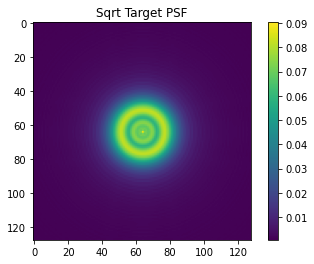

In [16]:
true_model = OpticalSystem(layers_true)
data = vmap(true_model)(wavels).sum(0)

plt.imshow(data**0.5)
plt.title("Sqrt Target PSF")
plt.colorbar()
plt.show()

In [17]:
# Optimisation model
layers_init = [
    CreateWavefront(optic_npix, optic_size),        # 1: Wavefront creation
    MultiplyArray(optic_npix, aperture),            # 2: Apply aperture
    ThinLens(optic_npix, focal_length, optic_size), # 3: Thin lens
    Pad(optic_npix, wf_npix),                       # 4: Pad
                                                    # 5: Fresnel proagation layer
    FresnelProp(wf_npix,                                # Wavefront size
              focal_length,                             # Focal length
              focal_length-1e-4),                       # Propagation distance intialise slightly before focus (symmetric grads about focus)
    NormaliseWavefront(wf_npix),                    # 6: Normalise PSF intensity (after FresnelProp)
    Interpolator(wf_npix, det_npix, det_pixelsize)] # 7: Interpolate WF onto detector

model = OpticalSystem(layers_init)

## Optimisaion

In [18]:
# A filter? It seems to work lol
filter_spec = jax.tree_map(lambda _: False, model)
filter_spec = eqx.tree_at(
    lambda tree: (tree.layers[4].z),
    filter_spec,
    replace=(True),
)

In [19]:
import functools as ft
@eqx.filter_jit
# @eqx.filter_value_and_grad
@ft.partial(eqx.filter_value_and_grad, filter_spec=filter_spec) # Slows down opt loop by facto of ~3?? Y tho
def loss_func(model, wavels, data):
    psf = vmap(model)(wavels).sum(0)
    return np.sum((psf - data)**2)

In [20]:
model = OpticalSystem(layers_init) # Re-initialise
initial_psf = vmap(model)(wavels).sum(0)
optim = optax.adam(1e-4)
opt_state = optim.init(model)

errors, grads_out = [], []
for i in tqdm(range(300)):
    loss, grads = loss_func(model, wavels, data)    
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    errors.append(loss)
    grads_out.append(grads)

  0%|          | 0/300 [00:00<?, ?it/s]

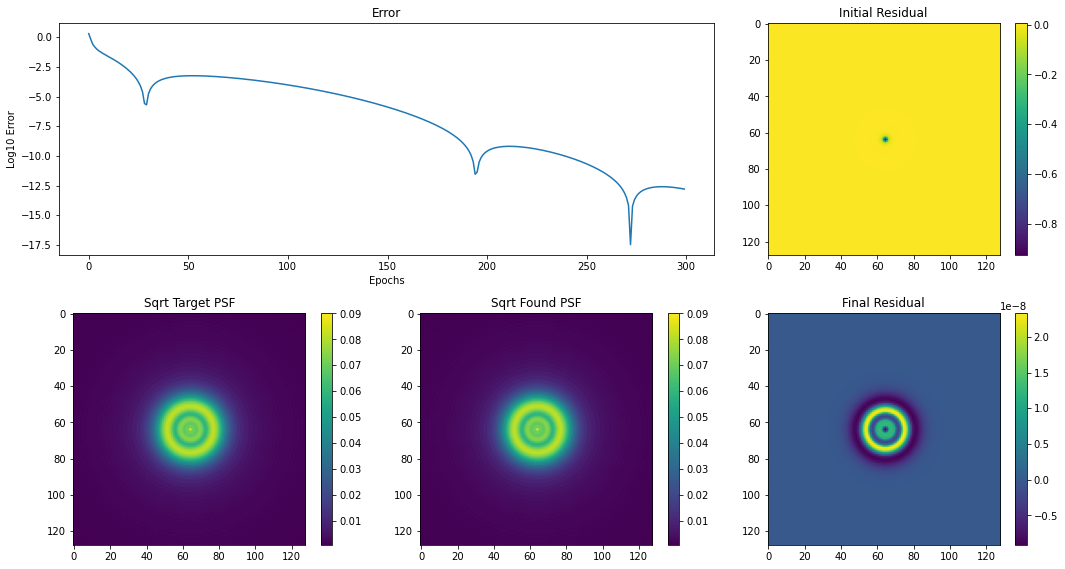

In [21]:
final_psf = vmap(model)(wavels).sum(0)
residual = data - final_psf
initial_residual = data - initial_psf

vmin = np.min(initial_residual)
vmax = np.max(initial_residual)

plt.figure(figsize=(15, 8))
ax = plt.subplot(2, 3, (1,2))
plt.title("Error")
plt.plot(np.arange(len(errors)), np.log10(np.array(errors)))
plt.xlabel("Epochs")
plt.ylabel("Log10 Error")

plt.subplot(2, 3, 3)
plt.title("Initial Residual")
plt.imshow(initial_residual)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.title("Sqrt Target PSF")
plt.imshow(data**0.5)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Sqrt Found PSF")
im = plt.imshow(final_psf**0.5)
cbar = plt.colorbar(im)
plt.subplot(2, 3, 6)

plt.title("Final Residual")
plt.imshow(residual)#, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.tight_layout()
plt.show()

In [23]:
model.layers[4].z

DeviceArray(9.999, dtype=float64)